In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.ops
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convolution Part

In [165]:
# Set random seed for reproducibility
torch.manual_seed(42)
# Download and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Load the entire dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [169]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.relu0 = nn.ReLU()
        self.maxpool0 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
#         self.soft1 = nn.Softmax()

    def forward(self, x):
        
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.maxpool0(x)

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
#         x = self.soft1(x)

        return x

In [170]:
# Instantiate the model, loss function, and optimizer
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [171]:
# Initialize variables to track the best model
best_val_accuracy = 0.0
best_epoch = 0

# Lists to store training and validation loss and accuracy for plotting
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 15  # Adjust the number of epochs as needed

# Record the start time
start_time = time.time()

# Train the model
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train

    # Validate the model
    net.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = 100 * correct_val / total_val

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(net.state_dict(), 'cnn_model.pth')

    # Append values to the lists for plotting
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(val_accuracy)

    # Print progress
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Avg. Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, '
          f'Avg. Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')

# Record the end time
end_time = time.time()

# Calculate and print the total time taken
total_time = end_time - start_time

print(f'Finished Training. Best Validation Accuracy: {best_val_accuracy}% (Epoch {best_epoch + 1})')


Epoch 1/15, Avg. Train Loss: 1.745, Train Accuracy: 35.545, Avg. Val Loss: 1.491, Val Accuracy: 45.020
Epoch 2/15, Avg. Train Loss: 1.346, Train Accuracy: 51.203, Avg. Val Loss: 1.262, Val Accuracy: 54.860
Epoch 3/15, Avg. Train Loss: 1.167, Train Accuracy: 58.633, Avg. Val Loss: 1.099, Val Accuracy: 61.240
Epoch 4/15, Avg. Train Loss: 1.030, Train Accuracy: 63.657, Avg. Val Loss: 1.013, Val Accuracy: 64.440
Epoch 5/15, Avg. Train Loss: 0.927, Train Accuracy: 67.638, Avg. Val Loss: 0.921, Val Accuracy: 67.170
Epoch 6/15, Avg. Train Loss: 0.825, Train Accuracy: 71.185, Avg. Val Loss: 0.875, Val Accuracy: 68.850
Epoch 7/15, Avg. Train Loss: 0.741, Train Accuracy: 74.112, Avg. Val Loss: 0.831, Val Accuracy: 70.860
Epoch 8/15, Avg. Train Loss: 0.669, Train Accuracy: 76.625, Avg. Val Loss: 0.815, Val Accuracy: 71.250
Epoch 9/15, Avg. Train Loss: 0.598, Train Accuracy: 79.132, Avg. Val Loss: 0.838, Val Accuracy: 71.820
Epoch 10/15, Avg. Train Loss: 0.520, Train Accuracy: 81.955, Avg. Val Los

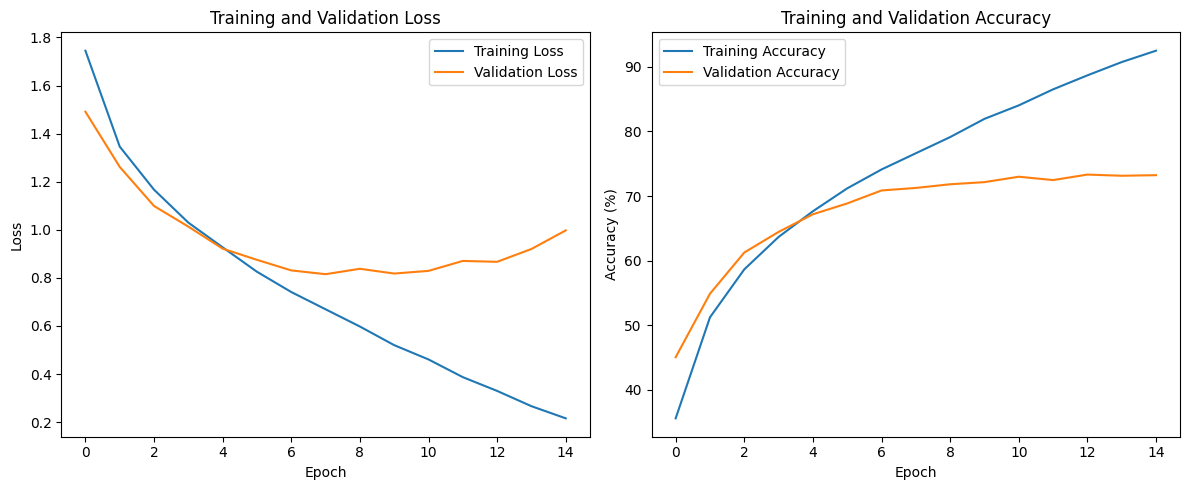

In [172]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [173]:
# Load the best model for testing
CNNet = CNN().to(device)
CNNet.load_state_dict(torch.load('cnn_model.pth'))
CNNet.eval()

# Test the model on the test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()


test_acc = 100 * correct_test / total_test
print(f'Accuracy on the test set: {test_acc}%')

Accuracy on the test set: 73.21%


# Deformable Convolution Part

In [174]:
# Set random seed for reproducibility
torch.manual_seed(42)
# Download and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Load the entire dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [175]:
class DeformConv2Layer(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformConv2Layer, self).__init__()

        self.stride = stride 
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size * kernel_size,
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        offset = self.offset_conv(x)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x
    

class DCNNet(nn.Module):
    def __init__(self):
        super(DCNNet, self).__init__()
        self.conv0 = DeformConv2Layer(3, 32, kernel_size=5, padding=2)
        self.relu0 = nn.ReLU()
        self.maxpool0 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = DeformConv2Layer(32, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = DeformConv2Layer(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = DeformConv2Layer(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 2 * 2, 64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
#         self.soft1 = nn.Softmax()

    def forward(self, x):
        
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.maxpool0(x)

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
#         x = self.soft1(x)

        return x
# Instantiate the model, loss function, and optimizer
Dnet = DCNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Dnet.parameters(), lr=0.0005)


In [176]:
# Initialize variables to track the best model
best_val_accuracy = 0.0
best_epoch = 0

# Lists to store training and validation loss and accuracy for plotting
train_loss_list_dnet = []
train_accuracy_list_dnet = []
val_loss_list_dnet = []
val_accuracy_list_dnet = []

num_epochs = 15  # Adjust the number of epochs as needed

# Record the start time
start_time = time.time()

# Train the model
for epoch in range(num_epochs):
    Dnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = Dnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train

    # Validate the model
    Dnet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = Dnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = 100 * correct_val / total_val

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(Dnet.state_dict(), 'dcn_model.pth')

    # Append values to the lists for plotting
    train_loss_list_dnet.append(avg_train_loss)
    train_accuracy_list_dnet.append(train_accuracy)
    val_loss_list_dnet.append(avg_val_loss)
    val_accuracy_list_dnet.append(val_accuracy)

    # Print progress
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Avg. Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, '
          f'Avg. Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')

    
# Record the end time
end_time = time.time()

# Calculate and print the total time taken
total_time_dnet = end_time - start_time

print(f'Finished Training. Best Validation Accuracy: {best_val_accuracy}% (Epoch {best_epoch + 1})')


Epoch 1/15, Avg. Train Loss: 1.694, Train Accuracy: 37.290, Avg. Val Loss: 1.466, Val Accuracy: 47.190
Epoch 2/15, Avg. Train Loss: 1.291, Train Accuracy: 53.380, Avg. Val Loss: 1.206, Val Accuracy: 56.620
Epoch 3/15, Avg. Train Loss: 1.086, Train Accuracy: 61.095, Avg. Val Loss: 1.014, Val Accuracy: 64.660
Epoch 4/15, Avg. Train Loss: 0.920, Train Accuracy: 67.305, Avg. Val Loss: 0.963, Val Accuracy: 66.490
Epoch 5/15, Avg. Train Loss: 0.805, Train Accuracy: 71.660, Avg. Val Loss: 0.875, Val Accuracy: 69.390
Epoch 6/15, Avg. Train Loss: 0.715, Train Accuracy: 74.830, Avg. Val Loss: 0.794, Val Accuracy: 72.080
Epoch 7/15, Avg. Train Loss: 0.635, Train Accuracy: 77.550, Avg. Val Loss: 0.769, Val Accuracy: 72.790
Epoch 8/15, Avg. Train Loss: 0.571, Train Accuracy: 80.147, Avg. Val Loss: 0.813, Val Accuracy: 71.580
Epoch 9/15, Avg. Train Loss: 0.499, Train Accuracy: 82.737, Avg. Val Loss: 0.753, Val Accuracy: 73.850
Epoch 10/15, Avg. Train Loss: 0.442, Train Accuracy: 84.382, Avg. Val Los

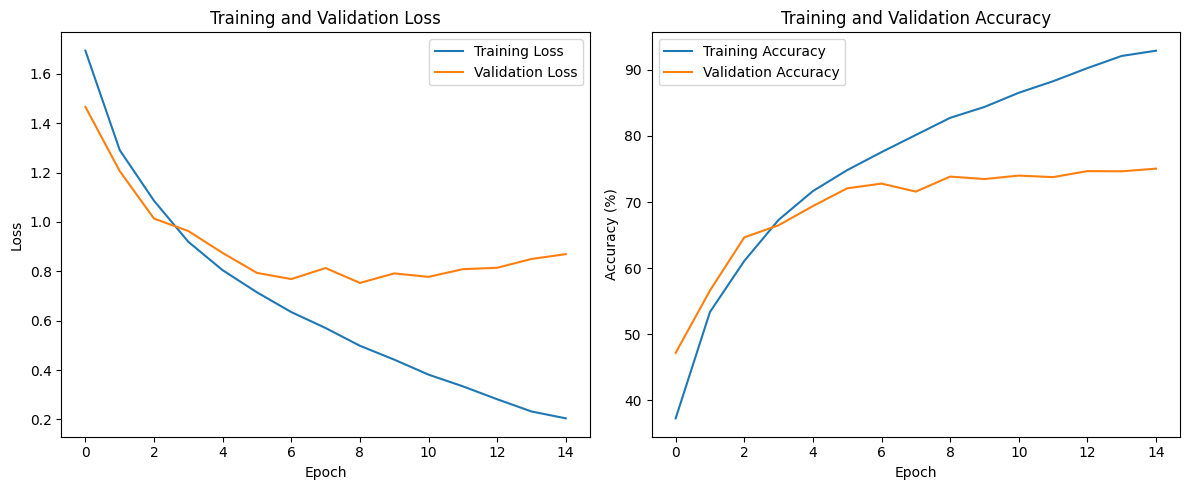

In [177]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list_dnet, label='Training Loss')
plt.plot(val_loss_list_dnet, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list_dnet, label='Training Accuracy')
plt.plot(val_accuracy_list_dnet, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [179]:
# Load the saved model
Dnet = DCNNet().to(device)
# Load the state_dict
state_dict = torch.load('dcn_model.pth')
Dnet.load_state_dict(state_dict)
Dnet.eval()  # Set the model to evaluation mode

# Test the model on the test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = Dnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
test_acc_dnet = 100 * correct_test / total_test
print(f'Accuracy on the test set: {test_acc_dnet}%')

Accuracy on the test set: 75.0%


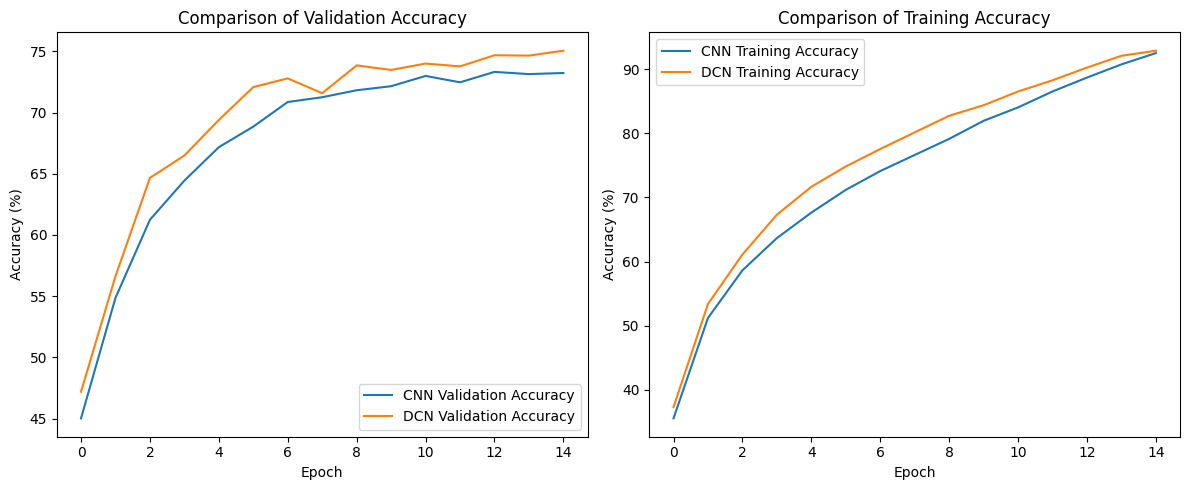

In [180]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracy_list, label='CNN Validation Accuracy')
plt.plot(val_accuracy_list_dnet, label='DCN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Validation Accuracy')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='CNN Training Accuracy')
plt.plot(train_accuracy_list_dnet, label='DCN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


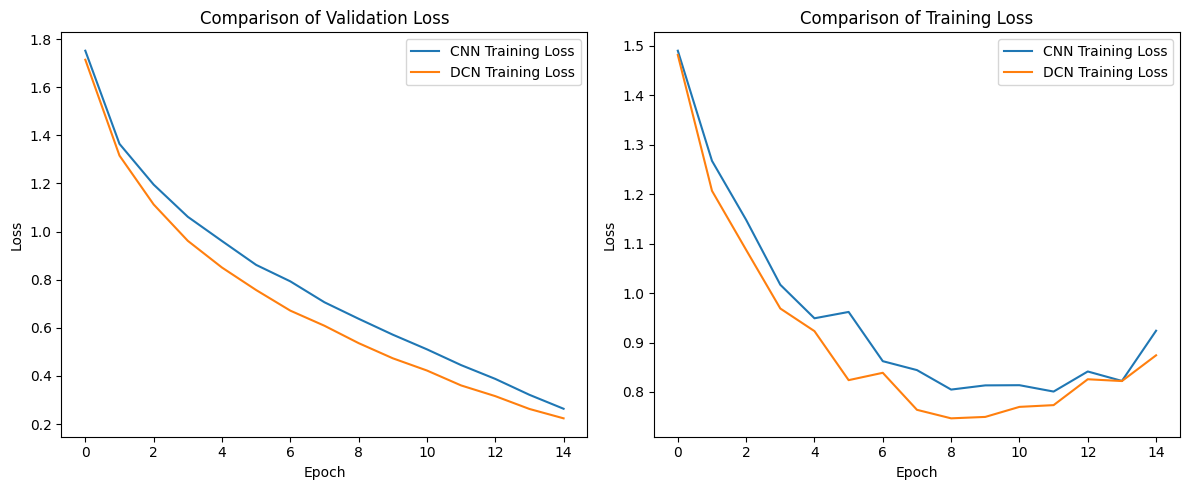

In [141]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='CNN Training Loss')
plt.plot(train_loss_list_dnet, label='DCN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Validation Loss')
plt.legend()
# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(val_loss_list, label='CNN Training Loss')
plt.plot(val_loss_list_dnet, label='DCN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [181]:
print(f'Total time taken by CNN: {total_time:.2f} seconds')
print(f'Total time taken by DCN: {total_time_dnet:.2f} seconds')

Total time taken by CNN: 127.56 seconds
Total time taken by DCN: 196.62 seconds


In [182]:
print(f'Accuracy on the test set by CNN: {test_acc}%')
print(f'Accuracy on the test set by DCN: {test_acc_dnet}%')

Accuracy on the test set by CNN: 73.21%
Accuracy on the test set by DCN: 75.0%
